# Apply RNA2seg on spatial data 




This notebook presents the workflow for applying RNA2Seg on Zarr-saved dataset. The process is structured into five main steps:

- **1-Create training patches** - Extract patches of a reasonable size to process efficiently (saved in the Zarr file). 
- **2-Initialize an RNA2segDataset**
- **3-Initialize a model RNA2Seg**
- **4-Run segmentation**: RNA2Seg is applied to the dataset to generate cell segmentations, which are then saved in a Zarr format.
- **5-Visualize segmentation**

**Test data for this notebook can be downloaded at: https://cloud.minesparis.psl.eu/index** \
This dataset is a subset of the mouse ileum dataset from Petukhov. et al. Nat Biotechnol 40, 345–354 (2022). https://doi.org/10.1038/s41587-021-01044-w .php/s/qw2HaDVxwwy1EOK

In [1]:
import rna2seg
rna2seg.__version__

'0.0.5'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import spatialdata as sd
from pathlib import Path

## Step 1: Create patches from Zarr files

In this step, the dataset (image + transcripts) is divided into patches of size `patch_width × patch_width` with an overlap of `patch_overlap`. This allows processing images of a manageable size while preserving spatial continuity.  

**Process** 
- The dataset, stored in Zarr format, is loaded.  
- Patches coordinates are saved as a `Shape` in the zarr: `sopa_patches_rna2seg_[patch_width]_[patch_overlap]`. 
- A `.rna2seg` directory is created to store the transcript data corresponding to each patch.  
- The transcript information for each patch is saved in CSV format for further processing.  


In [3]:
# MODIFY WITH YOUR PATH

merfish_zarr_path = "/media/tom/Transcend/open_merfish/test_spatial_data/test005/sub_mouse_ileum.zarr"

### load sdata and set sdata's parameters 
sdata = sd.read_zarr(merfish_zarr_path)
image_key = "staining_z3"
points_key = "transcripts"

channels_dapi= ["DAPI"]
channels_cellbound=["Cellbound1"]

gene_column_name="gene" 

patch_width = 1200
patch_overlap = 150
min_transcripts_per_patch = 0
folder_patch_rna2seg = Path(merfish_zarr_path) / f".rna2seg_{patch_width}_{patch_overlap}"

In [4]:
from rna2seg.dataset_zarr.patches import create_patch_rna2seg

### create patch in the sdata and precompute transcipt.csv for each patch with sopa
create_patch_rna2seg(sdata=sdata,
                    image_key=image_key,
                    points_key=points_key,
                    patch_width=patch_width,
                    patch_overlap=patch_overlap,
                    min_transcripts_per_patch=min_transcripts_per_patch,
                    folder_patch_rna2seg = folder_patch_rna2seg,
                    overwrite = True)
print(sdata)

[INFO] (sopa.patches._patches) Added 16 patche(s) to sdata['sopa_patches_rna2seg_1200_150']


[########################################] | 100% Completed | 3.64 sms
[########################################] | 100% Completed | 3.13 ss
SpatialData object, with associated Zarr store: /media/tom/Transcend/open_merfish/test_spatial_data/test005/sub_mouse_ileum.zarr
├── Images
│     └── 'staining_z3': DataTree[cyx] (5, 3704, 3704), (5, 1852, 1851), (5, 926, 926), (5, 463, 463), (5, 232, 232)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
└── Shapes
      ├── 'Cellbound1': GeoDataFrame shape: (569, 1) (2D shapes)
      ├── 'DAPI': GeoDataFrame shape: (409, 1) (2D shapes)
      ├── 'sopa_patches_rna2seg_1200_150': GeoDataFrame shape: (16, 3) (2D shapes)
      └── 'test_rnas2eg': GeoDataFrame shape: (546, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        test_rnas2eg (Shapes)
    ▸ 'microns', with elements:
        staining_z3 (Images), transcripts (Points), Cellbound1 (Shapes), DAPI (Shapes), sopa_patches_rna2seg_1200_

## Step 2: Initialize a RNA2segDataset

In [5]:
import albumentations as A
from rna2seg.dataset_zarr import RNA2segDataset

transform_resize  = A.Compose([
    A.Resize(width=512, height=512, interpolation=cv2.INTER_NEAREST),
])

dataset = RNA2segDataset(
    sdata=sdata,
    channels_dapi=channels_dapi,
    channels_cellbound=channels_cellbound,
    patch_width = patch_width,
    patch_overlap = patch_overlap,
    gene_column=gene_column_name,
    transform_resize = transform_resize,
    patch_dir=folder_patch_rna2seg
)

default shape_patch_key set to sopa_patches_rna2seg_1200_150
100%|██████████| 16/16 [00:00<00:00, 43.21it/s]
Number of valid patches: 9


## Step 3: Initialize a model RNA2seg

By default, the trained RNA2seg model is downloaded from Hugging Face. You can also specify `pretrained_model` to use your own RNA2seg model.

In [6]:
from rna2seg.models import RNA2seg


device = "cpu"


rna2seg = RNA2seg(
    device,
    net='unet',
    flow_threshold = 0.9,
    cellbound_flow_threshold = 0.4,
    pretrained_model = "default_pretrained"
)

No module named 'vmunet'
VMUnet not loaded
initiaisation of CPnet
Initiaisation of ChannelInvariantNet


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights from /home/tom/.cache/huggingface/hub/models--aliceblondel--RNA2seg/snapshots/26f9afe181ea58f808ecd9c0732c327936020b18/rna2seg.pt


## Step 4: Run segmentation 

We will run the segmentation on the entire dataset and save the results as a shape in the Zarr file.

In [7]:
from tqdm import tqdm
from rna2seg.utils import save_shapes2zarr

for i in tqdm(range(len(dataset))):
    input_dict = dataset[i]
    rna2seg.run(
        path_temp_save=folder_patch_rna2seg,
        input_dict=input_dict
    )

 11%|█         | 1/9 [00:04<00:37,  4.74s/it]

64 cells detected


 22%|██▏       | 2/9 [00:07<00:23,  3.39s/it]

62 cells detected


 33%|███▎      | 3/9 [00:10<00:20,  3.48s/it]

87 cells detected


 44%|████▍     | 4/9 [00:15<00:19,  3.98s/it]

112 cells detected


 56%|█████▌    | 5/9 [00:19<00:16,  4.03s/it]

103 cells detected


 67%|██████▋   | 6/9 [00:22<00:10,  3.49s/it]

57 cells detected


 78%|███████▊  | 7/9 [00:25<00:07,  3.60s/it]

87 cells detected


 89%|████████▉ | 8/9 [00:29<00:03,  3.49s/it]

65 cells detected


100%|██████████| 9/9 [00:31<00:00,  3.50s/it]

54 cells detected


### Add segmented cell in the spatialdata as shape
The segmentation of each patch are stored in ```folder_patch_rna2seg``` and can be add in the spataildata as follow : 

In [10]:
segmentation_shape_name = "test_rnas2eg"
save_shapes2zarr(dataset=dataset,
                 path_parquet_files=folder_patch_rna2seg,
                 segmentation_key=segmentation_shape_name,
                 )
sdata

100%|██████████| 9/9 [00:00<00:00, 321.16it/s]


len(list_all_cells) 691


Resolving conflicts: 100%|██████████| 872/872 [00:00<00:00, 4269.96it/s]

Added 546 cell boundaries in sdata['test_rnas2eg']


SpatialData object, with associated Zarr store: /media/tom/Transcend/open_merfish/test_spatial_data/test005/sub_mouse_ileum.zarr
├── Images
│     └── 'staining_z3': DataTree[cyx] (5, 3704, 3704), (5, 1852, 1851), (5, 926, 926), (5, 463, 463), (5, 232, 232)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
└── Shapes
      ├── 'Cellbound1': GeoDataFrame shape: (569, 1) (2D shapes)
      ├── 'DAPI': GeoDataFrame shape: (409, 1) (2D shapes)
      ├── 'image_patches': GeoDataFrame shape: (16, 3) (2D shapes)
      ├── 'sopa_patches_rna2seg_1200_150': GeoDataFrame shape: (16, 3) (2D shapes)
      └── 'test_rnas2eg': GeoDataFrame shape: (546, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        test_rnas2eg (Shapes)
    ▸ 'microns', with elements:
        staining_z3 (Images), transcripts (Points), Cellbound1 (Shapes), DAPI (Shapes), image_patches (Shapes), sopa_patches_rna2seg_1200_150 (Shapes)
with the following elements not in th

## Step 5: Visualize segmentation

Now, we visualize the results.
The following code extracts and plots three images: RNA transcripts, a selected staining image, and the corresponding segmentation.
Ensure that `staining_id` is valid to avoid indexing errors, and check that `bounds` are within dataset limits.

Get RNA image ...
Get image ...
Get segmentation image ...
Get image ...


100%|██████████| 52/52 [00:00<00:00, 69.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0].


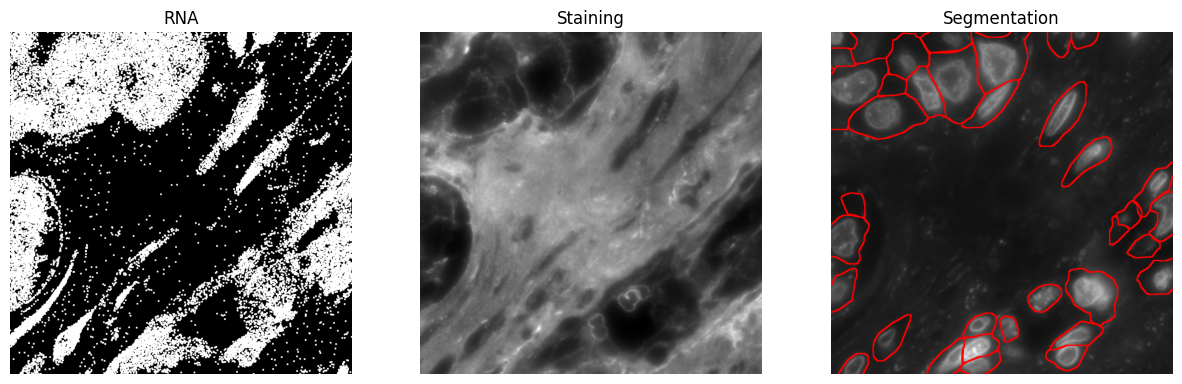

In [11]:
import matplotlib.pyplot as plt

# Parameters
key_segmentation="test_rnas2eg"
bounds = [2000, 2000, 3000, 3000,] # xmin, ymin, xmax, ymax
staining_id = 1 # Staining to plot

# Get images
rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
image = dataset.get_staining_img(bounds)
seg = dataset.get_segmentation_img(bounds, key_cell=key_segmentation)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(rna)
axes[0].set_title("RNA")
axes[0].axis("off")

axes[1].imshow(image[staining_id], cmap="grey")
axes[1].set_title("Staining")
axes[1].axis("off")

axes[2].imshow(seg)
axes[2].set_title("Segmentation")
axes[2].axis("off")

plt.show()